In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
import probfit

In [2]:
def abg_profile(x,p_s,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return p_s / denominator

In [3]:
#path = "/data/POL/HALOA/output_01274"
path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

IndexError: list index out of range

In [4]:
print myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max()
print myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max()
print myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max()

9530.21 10339.3
0.00878533 19915.8
77.7961 19838.0


In [5]:
po = np.copy(myhalo.st.pos3d)
ma = np.copy(myhalo.st.mass)

centro_com_st = nbe.real_center(po,ma,n=500)
print centro_com_st

[ 9685.29612879  9884.28529831  9819.18983706]


In [6]:
#offset = np.sqrt(centro_com_dm[0]**2+centro_com_dm[1]**2+centro_com_dm[2]**2)
#print offset

In [5]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
#print "density",centro
############
#centro_com = nbe.real_center(myhalo.st.pos3d,myhalo.st.mass)
#myhalo.center_shift(centro)
#print "centro COM",centro_com
print "centro dens",centro_rho

centro dens [ 9685.31347656  9883.21972656  9817.79785156]


In [ ]:
#vector = centro_com - centro_rho
#print np.sqrt((vector[0])**2+(vector[1])**2+(vector[2])**2)

# Centering and generating data


In [6]:
centro_com = centro_rho
#centro_com = np.array([-0.07954201, -0.02821755,  0.42987254])

myhalo.st.pos3d = myhalo.st.pos3d - centro_com
myhalo.dm.pos3d = myhalo.dm.pos3d - centro_com
myhalo.gs.pos3d = myhalo.gs.pos3d - centro_com

myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
myhalo.dm.r = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2)+(myhalo.dm.pos3d[:,2]**2))
myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))


In [7]:
myhalo.dm.mass = myhalo.dm.mass[np.where(myhalo.dm.r<300.)]
myhalo.dm.pos3d = myhalo.dm.pos3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.r = myhalo.dm.r[np.where(myhalo.dm.r<300)]

myhalo.st.mass = myhalo.st.mass[np.where(myhalo.st.r<300.)]
myhalo.st.pos3d = myhalo.st.pos3d[np.where(myhalo.st.r<300.)]
myhalo.st.r = myhalo.st.r[np.where(myhalo.st.r<300)]

myhalo.gs.mass = myhalo.gs.mass[np.where(myhalo.gs.r<300.)]
myhalo.gs.pos3d = myhalo.gs.pos3d[np.where(myhalo.gs.r<300.)]
myhalo.gs.r = myhalo.gs.r[np.where(myhalo.gs.r<300)]
myhalo.gs.rho = myhalo.gs.rho[np.where(myhalo.gs.r<300)]
myhalo.gs.hsml = myhalo.gs.hsml[np.where(myhalo.gs.r<300)]

In [8]:
#myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]
#vcheck = myhalo.dm.vel3d[np.where(myhalo.dm.r<174.)]

In [9]:
average = np.array([np.mean(myhalo.dm.vel3d[:,0]),
                    np.mean(myhalo.dm.vel3d[:,1]),
                    np.mean(myhalo.dm.vel3d[:,2])
                   ])
print average
#averageC = np.array([np.mean(vcheck[:,0]),
#                    np.mean(vcheck[:,1]),
#                    np.mean(vcheck[:,2])
#                   ])
#print averageC

#Halovelx=-17.99402546833644
#Halovely=-50.12026991953947
#Halovelz=-66.99018276193101
#average = np.array([Halovelx,Halovely,Halovelz])
myhalo.dm.vel3d = myhalo.dm.vel3d - average

[-82.07134247  12.28059483 -15.58530045]


In [10]:
print myhalo.p.simutokms

1402.49957094


In [11]:
myhalo.dm.R = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2))
myhalo.dm.vr = (myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,0] + \
                myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,1] + \
                myhalo.dm.vel3d[:,2]*myhalo.dm.pos3d[:,2])/ myhalo.dm.r

myhalo.dm.vphi = (-myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,1] +\
                   myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,0] )/ myhalo.dm.R 

In [12]:
print "stars       x_min = {0}, x_max = {1} ".format(myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max())
print "dark matter x_min = {0}, x_max = {1} ".format(myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max())
print "gas         x_min = {0}, x_max = {1} ".format(myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max())

stars       x_min = -222.337890625, x_max = 243.05859375 
dark matter x_min = -299.208984375, x_max = 299.787109375 
gas         x_min = -299.7109375, x_max = 295.915039062 


In [13]:
print len(myhalo.dm.pos3d)
print len(myhalo.st.pos3d)
print len(myhalo.gs.pos3d)

2768151
2154122
4747724


# Getting densities

In [14]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [15]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [16]:
center_dens_st = myhalo.st.pos3d[np.where(rho_st == rho_st.max())]
print center_dens_st

[[ 0.  0.  0.]]


In [17]:
pos_dens_dm = myhalo.dm.pos3d - center_dens_st[0]
r_cd = np.sqrt((pos_dens_dm[:,0]**2)+(pos_dens_dm[:,1]**2)+(pos_dens_dm[:,2]**2))

In [18]:
R_hsml = myhalo.gs.hsml.min()
print R_hsml

0.151946


# DM profile and fit

In [19]:
#centroide = nbe.real_ce(myhalo.dm.pos3d,myhalo.dm.mass)
#print centro_dm
#myhalo.center_shift(centro_dm)
#myhalo.redefine(2)
#print myhalo.dm.pos3d[np.where(rho_dm == rho_dm.max())]
#################################
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
#R_hsml = myhalo.gs.hsml()
##################################
r_p = np.logspace(np.log10(R_hsml),np.log10(300),30)
dens = np.array([])
dens_cd = np.array([])
mean = np.array([])
mean_cd = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell_cd = np.where((r_cd > r_p[i])&(r_cd < r_p[i+1])&(r_cd > R_hsml))
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > R_hsml))
    n = np.append(n,len(shell[0]))
    mass_cd = np.sum(myhalo.dm.mass[shell_cd])
    mass = np.sum(myhalo.dm.mass[shell])
    mean_cd = np.append(mean_cd,np.mean(rho_dm[shell_cd]))
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))
    volume = 4.* np.pi * ((r_p[i+1]**3)-(r_p[i]**3)) / 3.
    dens_cd = np.append(dens,mass_cd/volume)
    dens = np.append(dens,mass/volume)
dens_dm = dens
dens_dm_cd = dens_cd


In [20]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(p_s / denominator)

In [23]:
chi2log = probfit.Chi2Regression(abg_logprofile, np.log10(r_p[0:-1]), np.log10(dens_dm))
iminuit.describe(chi2log)

mi = iminuit.Minuit(chi2log,
                   p_s=0.9e7, limit_p_s=(1e7,1e10), error_p_s=.1,
                   r_s=4.,    limit_r_s=(3,6),      error_r_s=0.0001,
                   al=1.5,    limit_al=(0.5,5),     error_al=0.0001,
                   be=2,      limit_be=(1,8),       error_be=0.0001,
                   ga=0,      limit_ga=(0,4),
                   pedantic=False, print_level=0
                   )
my_fitarg = mi.fitarg
print my_fitarg

{u'error_p_s': 0.1, 'be': 2, u'fix_al': False, u'limit_al': (0.5, 5), u'error_r_s': 0.0001, u'error_be': 0.0001, u'limit_r_s': (3, 6), u'fix_be': False, u'error_al': 0.0001, 'r_s': 4.0, u'fix_ga': False, 'al': 1.5, u'error_ga': 1.0, u'limit_ga': (0, 4), u'fix_p_s': False, 'ga': 0, u'fix_r_s': False, u'limit_p_s': (10000000.0, 10000000000.0), 'p_s': 9000000.0, u'limit_be': (1, 8)}


In [24]:
mi.migrad();

In [26]:
texto = "rho_0     =  {0:.3e}\nr_s       =  {1}\n".format(mi.values['p_s'],mi.values['r_s'])+\
         "alpha     =  {0}\nbeta      =  {1}\n".format(mi.values['al'],mi.values['be'])+\
         "gamma     =  {0}".format(mi.values['ga'])

print texto


rho_0     =  4.790e+07
r_s       =  3.95463912941
alpha     =  2.61361627476
beta      =  2.58526368372
gamma     =  0.000260735167927


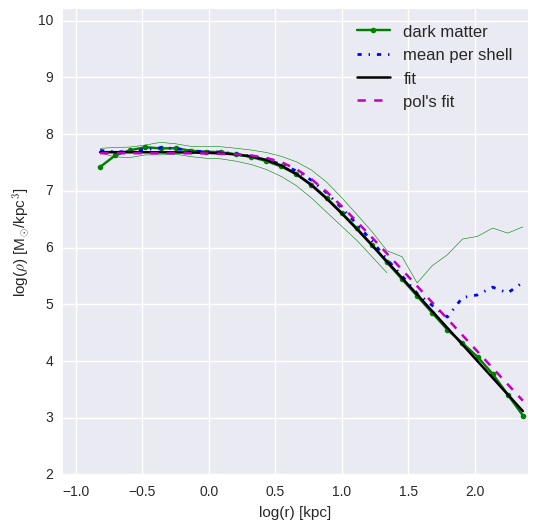

In [27]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
#ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")


ax.plot(np.log10(r_p[0:-1]),np.log10(mean),'b-.',linewidth=2, label="mean per shell")
ax.plot(np.log10(r_p[0:-10]),np.log10(((mean-std)*((mean-std)>0)+0.0001)[:-9]),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p[0:-1]),np.log10(mean+std),'g-',linewidth=0.4)
ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],mi.values['p_s'],mi.values['r_s'],mi.values['al'],mi.values['be'],mi.values['ga'])),
        'k-',linewidth=1.8,markersize=4, label="fit")


ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],10**7.663,4.425,2.895,2.541,8e-9
                            )),
        'm--',linewidth=1.8,markersize=4, label="pol's fit")

ax.set_ylim([2,10.2])
ax.set_xlim([-1.1,2.4])
y =[i for i in range(1,14)]
x_p03 =[np.log(R_P03) for i in range(1,14)]
#ax.plot(x_p03,y)
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'log($\rho $) [M$_{\odot}$/kpc$^3$]')
#ax.text(-0.8,4,texto)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

# Stars

In [30]:
r_p_st = np.logspace(-1,np.log10(20),60)
dens = np.array([])
m = np.array([])
v = np.array([])
n_bar = np.array([])
mean_st = np.array([])
std_st = np.array([])
n_bar=np.array([])
for i in range(len(r_p_st)-1):
    shell = np.where((myhalo.st.r > r_p_st[i])&(myhalo.st.r < r_p_st[i+1]))
    n_bar = np.append(n_bar,len(shell[0]))
    mass = np.sum(myhalo.st.mass[shell])
    mean_st = np.append(mean_st,np.mean(rho_st[shell]))
    std_st = np.append(std_st,np.std(rho_st[shell]))
    volume = 4.* np.pi * ((r_p_st[i+1]**3)-(r_p_st[i]**3)) / 3.
    dens = np.append(dens,mass/volume)
dens_st = dens

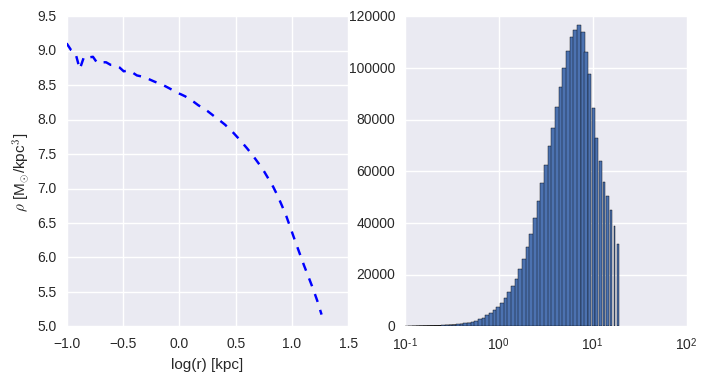

In [31]:
fig , [ax,ax1] = plt.subplots(1,2,figsize=[8,4])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'b--', label="data")
#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])
ax1.bar(r_p_st[0:-1],n_bar)
ax1.set_xscale('log')
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [50]:
def McMBulge(x,B_0,r0,al,r_cut):
        bulge = B_0 * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

def McMDisc(x,D_0,Rd):
        disc = D_0 * np.exp( - x / Rd )
        return disc
    
def stars(x,B_0,r0,al,r_cut,D_0,Rd):
    x = 10**x
    return np.log10(McMBulge(x,B_0,r0,al,r_cut)+McMDisc(x,D_0,Rd))

    

In [51]:
chi2bar = probfit.Chi2Regression(stars, np.log10(r_p_st[0:-1]),np.log10(dens_st[0:]))
iminuit.describe(chi2bar)

['B_0', 'r0', 'al', 'r_cut', 'D_0', 'Rd']

In [52]:
m = iminuit.Minuit(chi2bar,
                    B_0=0.9e7, limit_B_0=(1e7,1e11), error_B_0=.1,
                    r0=0.02,     limit_r0=(1e-9,6),       error_r0=0.0001,
                    al=0.6,    limit_al=(0.0,5),     error_al=0.0001,
                    r_cut=3,   limit_r_cut=(1,4),    error_r_cut=0.0001,
                    D_0=3e9,     limit_D_0=(1e7,1e10),
                    Rd=1.5,    limit_Rd=(0,8),
                    pedantic=False, print_level=0
                   )
my_fitarg = m.fitarg
print my_fitarg

{u'fix_D_0': False, u'error_r0': 0.0001, u'limit_r_cut': (1, 4), u'error_B_0': 0.1, u'fix_B_0': False, 'D_0': 3000000000.0, u'error_r_cut': 0.0001, 'al': 0.6, u'limit_Rd': (0, 8), u'fix_al': False, 'Rd': 1.5, u'fix_Rd': False, u'limit_D_0': (10000000.0, 10000000000.0), 'r0': 0.02, 'r_cut': 3, u'limit_al': (0.0, 5), u'fix_r0': False, u'fix_r_cut': False, u'error_Rd': 1.0, 'B_0': 9000000.0, u'limit_r0': (1e-09, 6), u'error_al': 0.0001, u'limit_B_0': (10000000.0, 100000000000.0), u'error_D_0': 1.0}


In [53]:
m.migrad()

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 1.775912226421211e-05, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 0.099764476127343, 'nfcn': 1165},
 [{'is_const': False, 'name': 'B_0', 'has_limits': True, 'value': 1550869518.2100778, 'number': 0, 'has_lower_limit': True, 'upper_limit': 100000000000.0, 'lower_limit': 10000000.0, 'has_upper_limit': True, 'error': 5079966791.543224, 'is_fixed': False},
  {'is_const': False, 'name': 'r0', 'has_limits': True, 'value': 0.13513556873345664, 'number': 1, 'has_lower_limit': True, 'upper_limit': 6.0, 'lower_limit': 1e-09, 'has_upper_limit': True, 'error': 4.416871682257566, 'is_fixed': False},
  {'is_const': False, 'name': 'al', 'has_limits': True, 'value': 1.004788559410879, 'number': 2, 'has_lower_limit': True, 'upper_limit': 5.0, 'lower_limit': 0.0, 'has_upper_limit':

In [54]:
m.values

{'B_0': 1550869518.2100778,
 'D_0': 89318546.15597686,
 'Rd': 2.7797533617371464,
 'al': 1.004788559410879,
 'r0': 0.13513556873345664,
 'r_cut': 3.99999702296487}

## McMillan fit

In [55]:
# B_0,D_0,r0,al,r_cut,Rd
# a,b,M,ah,Mh
array = [m.values['B_0'],m.values['D_0'],m.values['r0'],m.values['al'],m.values['Rd'],m.values['r_cut']]
texto = "B_0        =  {0:.4}\nD_0        =  {1:.4}\nr0         =  {2}\nalpha      =  {3}\nr_cut      =  {4} \nrd         =  {3}".format(m.values['B_0'],m.values['D_0'],m.values['r0'],m.values['al'],m.values['Rd'],m.values['r_cut'])

print texto


B_0        =  1.551e+09
D_0        =  8.932e+07
r0         =  0.135135568733
alpha      =  1.00478855941
r_cut      =  2.77975336174 
rd         =  1.00478855941


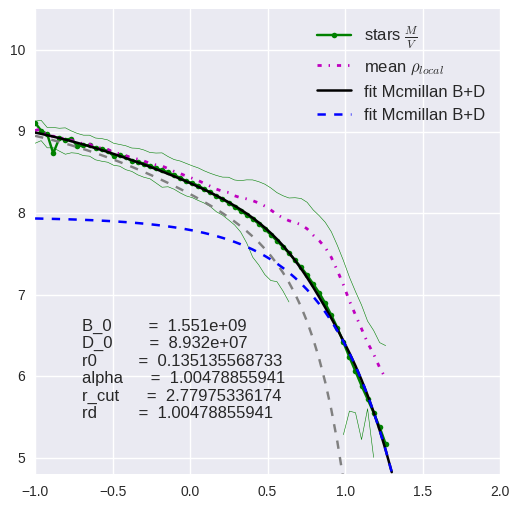

In [63]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

ax.set_xlim([-1,2])
ax.set_ylim([4.8,10.5])

ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st),np.log10(McMBulge(r_p_st,m.values['B_0'],m.values['r0'],
                                           m.values['al'],m.values['r_cut'])),'gray', ls='--')
sumation = (McMBulge(r_p_st,m.values['B_0'],m.values['r0'],m.values['al'],m.values['r_cut'])) +\
           (McMDisc(r_p_st,m.values['D_0'],m.values['Rd']))
ax.plot(np.log10(r_p_st),np.log10(sumation),
        'k-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

ax.plot(np.log10(r_p_st),np.log10(McMDisc(r_p_st,m.values['D_0'],m.values['Rd'])),
        'b--',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

ax.text(-.7,5.5,texto)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

# Gas

In [289]:
r_p_gs = np.logspace(-1,np.log10(20),20)
dens = np.array([])
m = np.array([])
v = np.array([])
n_bar = np.array([])
mean_gs = np.array([])
std_gs = np.array([])
n_bar=np.array([])
for i in range(len(r_p_gs)-1):
    shell = np.where((myhalo.gs.r > r_p_gs[i])&(myhalo.gs.r < r_p_gs[i+1]))
    n_bar = np.append(n_bar,len(shell[0]))
    mass = np.sum(myhalo.gs.mass[shell])
    mean_gs = np.append(mean_gs,np.mean(myhalo.gs.rho[shell]))
    std_gs = np.append(std_gs,np.std(myhalo.gs.rho[shell]))
    volume = 4.* np.pi * ((r_p_gs[i+1]**3)-(r_p_gs[i]**3)) / 3.
    dens = np.append(dens,mass/volume)

     
#dens[np.where(dens==0)] = 1e-2   

dens_gs = dens



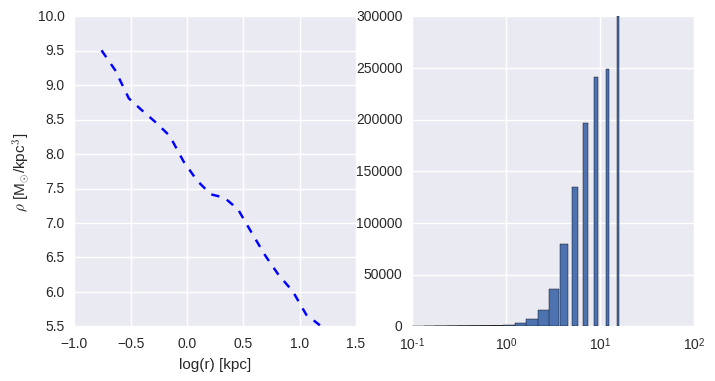

In [290]:
fig , [ax,ax1] = plt.subplots(1,2,figsize=[8,4])
ax.plot(np.log10(r_p_gs[0:-1]),np.log10(dens_gs),'b--', label="data")
#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])
ax1.bar(r_p_gs[0:-1],n_bar)
ax1.set_xscale('log')
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [254]:

def McMgas(x,G_0,Rm, Rd):
        disc = G_0 * np.exp( -(Rm / x) - (x / Rd) )
        return disc
    
def gas(x,G_0,Rm, Rd):
    x = 10**x
    return np.log10(McMgas(x,G_0,Rm, Rd))

    

In [262]:
chi2gas = probfit.Chi2Regression(McMgas, (r_p_gs[0:-1]), (dens_gs[0:]))
iminuit.describe(chi2gas)

['G_0', 'Rm', 'Rd']

In [279]:
m = iminuit.Minuit(chi2gas,
                    G_0=0.9e7, limit_G_0=(0,1e15), error_G_0=.1,
                    Rm=2,     limit_Rm=(0.001,5),       error_Rm=0.0001,
                    Rd=5,    limit_Rd=(0.00001,5),     error_Rd=0.0001,
                    pedantic=False, print_level=0
                   )
my_fitarg = m.fitarg
print my_fitarg

{u'limit_Rm': (0.001, 5), u'fix_Rm': False, 'G_0': 9000000.0, u'limit_Rd': (1e-05, 5), u'fix_G_0': False, 'Rd': 5, u'fix_Rd': False, u'error_Rd': 0.0001, u'error_G_0': 0.1, 'Rm': 2, u'limit_G_0': (0, 1000000000000000.0), u'error_Rm': 0.0001}


In [280]:
m.migrad()

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 0.0013148641245238166, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 2.2524853759120456e+18, 'nfcn': 257},
 [{'is_const': False, 'name': 'G_0', 'has_limits': True, 'value': 37804580607.37013, 'number': 0, 'has_lower_limit': True, 'upper_limit': 1000000000000000.0, 'lower_limit': 0.0, 'has_upper_limit': True, 'error': 33.7230224609375, 'is_fixed': False},
  {'is_const': False, 'name': 'Rm', 'has_limits': True, 'value': 0.001, 'number': 1, 'has_lower_limit': True, 'upper_limit': 5.0, 'lower_limit': 0.001, 'has_upper_limit': True, 'error': 0.0, 'is_fixed': False},
  {'is_const': False, 'name': 'Rd', 'has_limits': True, 'value': 0.05641582415725162, 'number': 2, 'has_lower_limit': True, 'upper_limit': 5.0, 'lower_limit': 1e-05, 'has_upper_limit': True, 'error': 2.5266823

In [281]:
m.values

{'G_0': 37804580607.37013, 'Rd': 0.05641582415725162, 'Rm': 0.001}

In [270]:
#print dens
#print r_p_gs

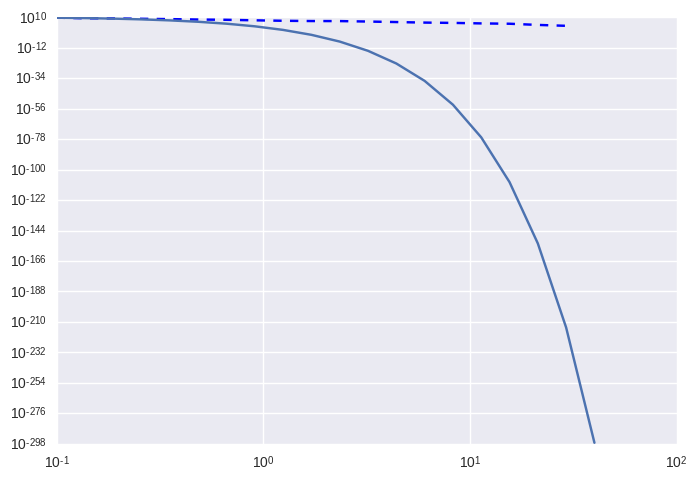

In [284]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([-15,15])
#ax.set_xlim([0,5])
ax.plot((r_p_gs[0:-1]),(dens_gs),'b--', label="data")

ax.plot((r_p_gs),(McMgas(r_p_gs,m.values['G_0'],.0001,m.values['Rd'])) )   
#ax.plot(np.log10(r_p_gs),(gas(np.log10(r_p_gs),m.values['G_0'],m.values['Rm'],m.values['Rd'])) )   


<Container object of 49 artists>

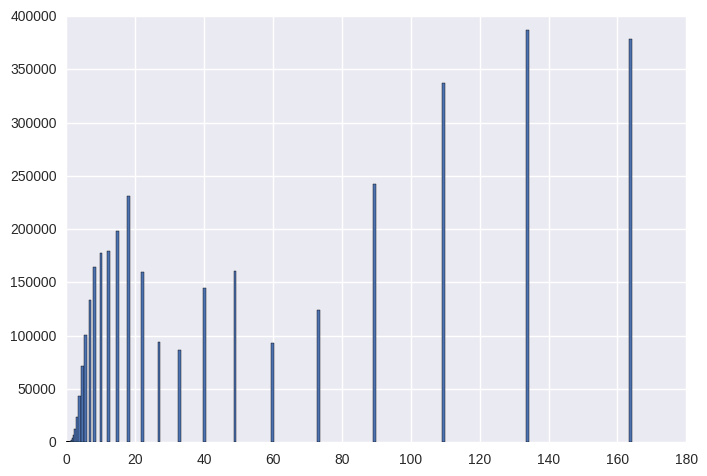

In [261]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([-15,15])
#ax.set_xlim([-15,15])

bins = np.logspace(-2,np.log10(200),50)
fdv = np.histogram(myhalo.gs.r,bins=bins)
ax.bar(fdv[1][:-1],fdv[0])

In [34]:
# B_0,D_0,r0,al,r_cut,Rd
# a,b,M,ah,Mh
mins = np.array([0, 0, 7e9,  0,4e8])
maxs = np.array([5, 0.6, 7e11,  1, 9e10])
fitabg =mia_bar_fit(mins=mins, maxs=maxs)

params,chi2mia = fitabg.bestfit(r_p_st[0:-1],dens_st,n_bar)
texto = "a_mia        =  {0}\nb_mia        =  {1}\nMmia         =  {2:.6e}\na_h          =  {3}\nM_h          =  {4:.6e} \nchi2         = {5} \nReducedChi2  = {6}".format(params[0],params[1],params[2],params[3],params[4],chi2mia, chi2mia / (len(dens_st-len(params))))

print texto

a_mia        =  2.74487607148
b_mia        =  0.544121445458
Mmia         =  1.366747e+10
a_h          =  0.999999997757
M_h          =  8.198800e+08 
chi2         = 0.204220270871 
ReducedChi2  = 0.0070420783059


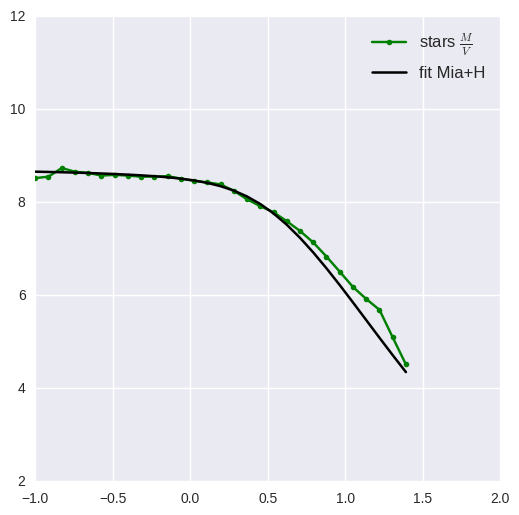

In [35]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

ax.set_xlim([-1,2])
ax.set_ylim([2,12])

#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mia_H(r_p_st[0:-1],params[0],params[1],params[2],params[3],params[4])),
        'k-',linewidth=1.8,markersize=4, label="fit Mia+H")

#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st[0:-1],paramsMc[0],paramsMc[1],paramsMc[2],paramsMc[3],paramsMc[4],paramsMc[5])),
#       'b-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

# Velocity distributions

before  2768151
after  32675
min = 8.16956043243, max = 540.122741699


<Container object of 49 artists>

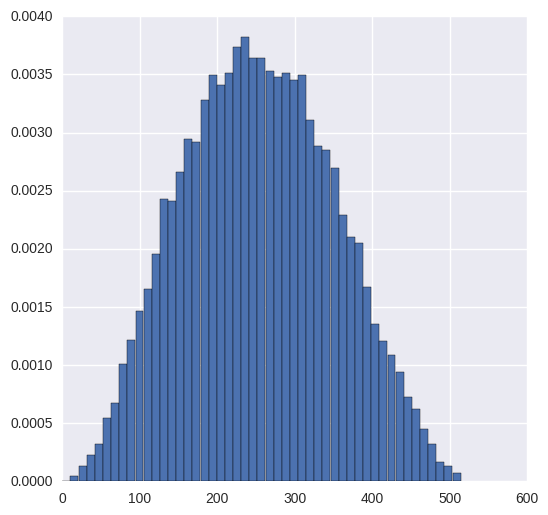

In [291]:
print "before ", len(myhalo.dm.vel3d)
shell8kpc = (myhalo.dm.r > 7.5) & (myhalo.dm.r < 8.5)
vel3d_8kpc = myhalo.dm.vel3d[shell8kpc]
print "after ", len(vel3d_8kpc)
speed_8kpc = np.sqrt(vel3d_8kpc[:,0]**2 + vel3d_8kpc[:,1]**2 +vel3d_8kpc[:,2]**2)
print "min = {0}, max = {1}".format(speed_8kpc.min(),speed_8kpc.max())
bins = np.linspace(0,514,50)
w = 514 / 50.
fdv = np.histogram(speed_8kpc,bins=bins,normed=1)
fig, ax = plt.subplots(figsize=[6,6])
ax.bar(fdv[1][0:-1],fdv[0], width=w)


In [14]:
print np.mean(speed_8kpc)
print np.std(speed_8kpc)

250.479
95.2115


In [18]:
myhalo.rotate_galaxy()


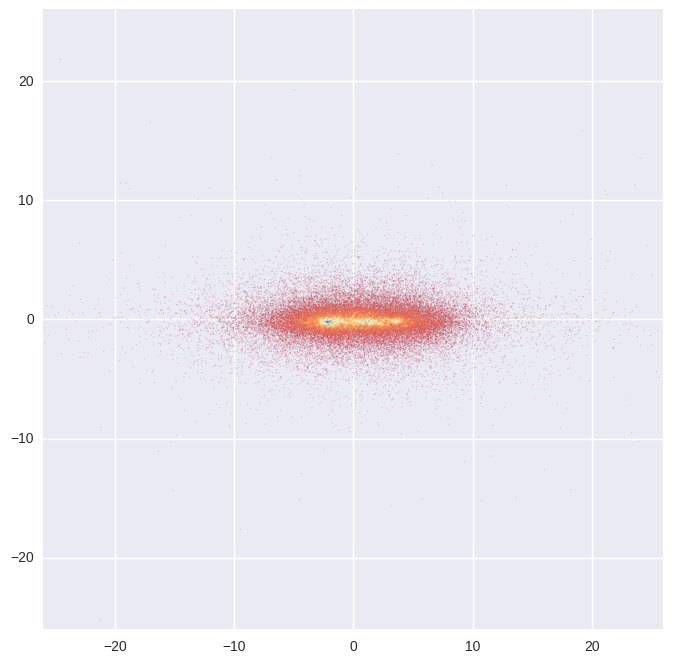

In [19]:
fig ,ax = plt.subplots(figsize=[8,8])
cm = plt.cm.get_cmap('RdYlBu')
ax.set_xlim([-26,26])
ax.set_ylim([-26,26])

co = (myhalo.st.pos3d[:,1]>-.1)&(myhalo.st.pos3d[:,1]<.1)
ax.scatter(myhalo.st.pos3d[co,0],myhalo.st.pos3d[co,2],c=rho_st[co], cmap=cm,vmin=1e7, vmax=9e8,lw=0, s=0.8,alpha=0.2)

In [20]:
print rho_st.min()

0.0233994


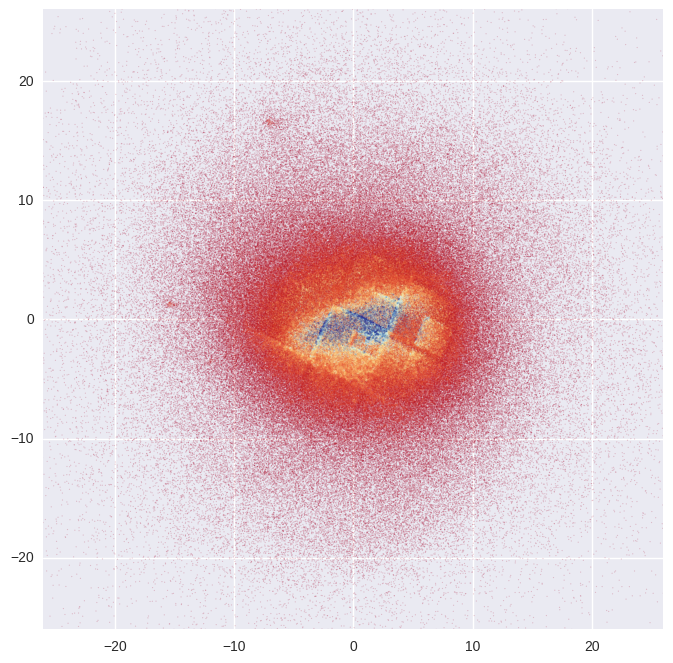

In [21]:
fig ,ax = plt.subplots(figsize=[8,8])
cm = plt.cm.get_cmap('RdYlBu')
ax.set_xlim([-26,26])
ax.set_ylim([-26,26])

co = (myhalo.st.pos3d[:,2]>-3)&(myhalo.st.pos3d[:,2]<-0.5)
ax.scatter(myhalo.st.pos3d[co,0],myhalo.st.pos3d[co,1],c=rho_st[co], cmap=cm,vmin=1e6, vmax=2e8,lw=0, s=0.8,alpha=0.2)

In [17]:
def beta_shell(r,r2):
    shell_condition = (myhalo.dm.r > r)&(myhalo.dm.r < r2)
    vphi_shell = myhalo.dm.vphi[shell_condition]
    vr_shell = myhalo.dm.vr[shell_condition]
    sigmaT_shell = np.std(vphi_shell)
    sigmar_shell = np.std(vr_shell)
    return 1-(sigmaT_shell/sigmar_shell)

get_beta_shell = np.vectorize(beta_shell)
    

In [20]:
r_sample = np.linspace(0,300,60)
r1 = r_sample[:-1]
r2 = r_sample[1:]
beta_in_shell = get_beta_shell(r1,r2)

cen = r1 +(r2-r1)/ 2


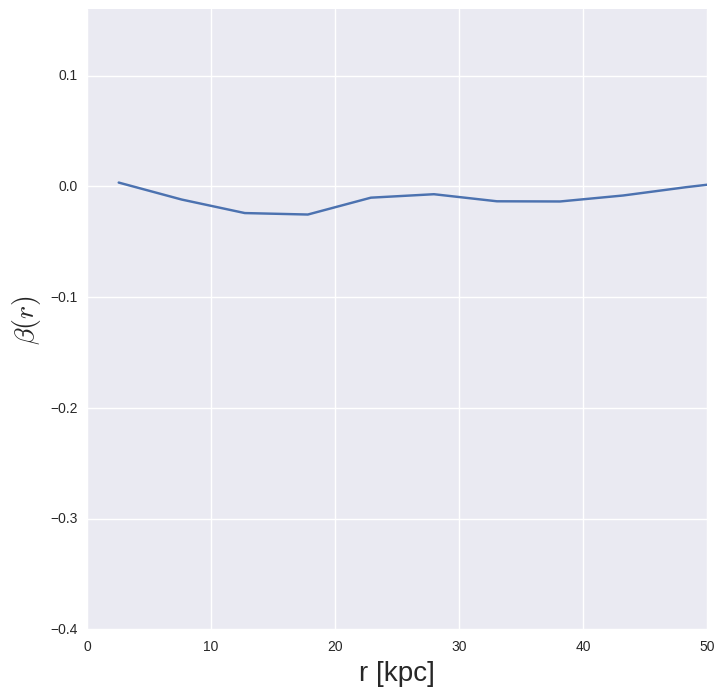

In [21]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([0,50])
ax.plot(cen,beta_in_shell)
ax.set_ylabel(r'$\beta(r)$',fontsize=20)
ax.set_xlabel(r'r [kpc]',fontsize=20)
ax.set_ylim([-0.4,0.16])
y = [i for i in np.arange(-0.2,0.18,0.01)]
x = [172 for i in y]
#ax.set_xscale('log')
ax.plot(x,y,'k--', alpha=0.5)
#ax.text(162,0.01,r'R$_{200}$',fontsize=20)
#ax.text(20,0.1,r'$\beta(r) = 1 - \frac{\sigma_T}{\sigma_r}$',fontsize=25)

In [ ]:
myhalo.dm.vel3d = myhalo.dm.vel3d + average

In [12]:
#myhalo.center_shift(-centroide)
#pos = myhalo.dm.pos3d
#myhalo.dm.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
#r_baryons = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
#myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))

In [23]:
mean_= (mean-std)*(((mean-std)>0))
mean_[-9]=0.0001
mean_

array([  3.88556520e+08,   3.43511608e+08,   3.45881896e+08,
         3.08148032e+08,   2.98571624e+08,   2.91072816e+08,
         2.79404464e+08,   2.42528688e+08,   2.19849232e+08,
         1.89118936e+08,   1.60813576e+08,   1.24682960e+08,
         8.85305800e+07,   5.81526140e+07,   3.46797080e+07,
         1.96198960e+07,   1.06931690e+07,   5.73106250e+06,
         3.07652838e+06,   4.68364875e+05,   1.00000000e-04,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00])

In [ ]:
#myhalo.center_shift(-centroide)
#pos = myhalo.st.pos3d
#myhalo.st.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))

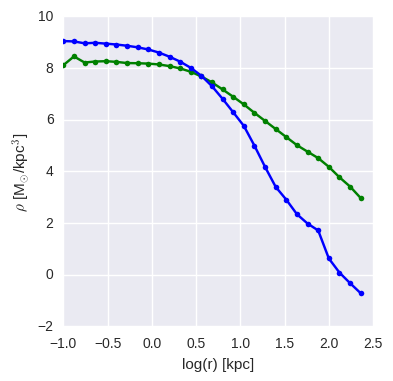

In [71]:
fig , ax = plt.subplots(figsize=[4,4])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")

#ax.set_ylim([2,10.2])
#ax.set_xlim([-1.1,2.4])

ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [ ]:
np.log10(1956566876)

In [5]:
myhalo.r_virial(600)

| r_200 = 172.842710452
---- taking particles inside 2.5 * r200
%%flag dm
%%flag st
%%flag gs
| number of praticles inside 2.5 * r200 
| dm mass       =  8.05216190464e+11 M_sun
| p_dm_200      =  3488602 particles
| stellar mass  =  79916277760.0 M_sun
| p_st_200      =  2161812 psrticles
| gas mass      =  79578636288.0 M_sun
| p_gs_200      =  7828605 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |15,0,0|
| D =|0,12,0|
|    |0,0,1|


In [27]:
myhalo.save_galaxy("snap1.g2","gadget2","halo")

1
1


In [ ]:
myhalo.save_galaxy("snap1st.g2","gadget2","stars")

In [1]:
myhalo.save_galaxy("snap1gs.g2","gadget2","gas")

NameError: name 'myhalo' is not defined

In [15]:
with open("Halo-C-Stars-pos-rho.txt", "w") as text_file:
    text_file.write("# Stars position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.st.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.st.pos3d[i,0],
                                                           myhalo.st.pos3d[i,1],
                                                           myhalo.st.pos3d[i,2],
                                                           rho_st[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.st.pos3d)))

In [16]:
with open("Halo-C-Gas-pos-rho.txt", "w") as text_file:
    text_file.write("# Gas position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.gs.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.gs.pos3d[i,0],
                                                           myhalo.gs.pos3d[i,1],
                                                           myhalo.gs.pos3d[i,2],
                                                           myhalo.gs.rho[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.gs.pos3d)))

In [17]:
with open("Halo-C-DarkMatter-pos-rho.txt", "w") as text_file:
    text_file.write("# DM position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.dm.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.dm.pos3d[i,0],
                                                           myhalo.dm.pos3d[i,1],
                                                           myhalo.dm.pos3d[i,2],
                                                           rho_dm[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.dm.pos3d)))

In [17]:
with open("Halo-B-Anisotropy.txt", "w") as text_file:
    text_file.write("# Halo beta paramiter of HALO B\n# R200 = 172 kpc \n# format:\n#  r [kpc] beta(r) \n")
    for i in range(len(r_sample)): 
        text_file.write("{0:.4e} {1:.4e} \n".format(r_sample[i], beta_in_shell[i]))
    text_file.write("# TOTAL = {0}".format(len(r_sample)))